In [2]:
import h5py
import numpy as np
from gwpy.timeseries import TimeSeries
import bilby
import bilby_pipe
#from pesummary.io import read
import os
import sys
#sys.path.append("../vitamin_c/")
model_dir = "/home/joseph.bayley/public_html/CBC/vitamin_O4MDC/vitamin_fit_c_run6_256_tanhdata_psiX_vmfsky_xyperiod_maxpool/"
sys.path.append(model_dir)
from vitamin_c_model_fit import CVAE
sys.path.append("../vitamin_c/")
from vitamin_c_fit import get_params
sys.path.append("../notebooks")
from test_on_o4 import plot_posterior_n
#import load_data
import load_data_fit
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.signal as signal
import corner
import random
from astropy.time import Time
from astropy import coordinates as coord

In [5]:
%matplotlib inline

In [6]:
#trigger_time = 1325030418
#trigger_time = 1325030418.015282
trigger_time = 1325030418.015282
duration = 10
end_time = trigger_time + 1.9
start_time = end_time - duration

end_slice = trigger_time + 0.25
start_slice = end_slice - 1

roll_off = 0.4  
psd_duration = 32 * duration
psd_start_time = start_time - psd_duration
psd_end_time = start_time


In [7]:
asd_file = "/home/joseph.bayley/projects/o4_online_pe_mdc/data/asd_files/aLIGO_O4_high_asd.txt"

In [8]:
ifo_list = bilby.gw.detector.InterferometerList([])
for i, det in enumerate(["H1","L1"]):
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    
    #ts = TimeSeries.read("/home/joseph.bayley/data/CBC/O4MDC/o4_online/U1/{}-O4MDC-1325029266-1184.gwf".format(det),"{}:O4MDC".format(det))
    ts = TimeSeries.read("/home/joseph.bayley/data/CBC/O4MDC/o4_online/U1/{}-O4MDC-1325029268-1152.gwf".format(det),"{}:O4MDC".format(det), start = start_slice, end = end_slice)
    #ts = TimeSeries.read("/home/joseph.bayley/projects/o4_online_pe_mdc/data/Utest/{}-O4MDC-1325029268-1152.gwf".format(det),"{}:O4MDC".format(det))
    ts_resamp = ts.resample(256)
    ifo.strain_data.set_from_gwpy_timeseries(ts_resamp)
    
    #psd_data = TimeSeries.read("/home/joseph.bayley/data/CBC/O4MDC/o4_online/U1/{}-O4MDC-1325029266-1184.gwf".format(det),"{}:O4MDC".format(det), start = psd_start_time, end = psd_end_time)
    #psd_data_resamp = psd_data.resample(256)
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file=asd_file)
    """
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
            fftlength=duration,
            overlap=0,
            window=("tukey", psd_alpha),
            method="median"
    )
    
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value)
    """
    ifo_list.append(ifo)
    

In [9]:
whitened_h = []
for ifo in ifo_list:
    Nt = int(ifo.sampling_frequency*ifo.duration)
    h_fd = ifo.strain_data.frequency_domain_strain
    whitened_h_fd = h_fd/ifo.amplitude_spectral_density_array
    whitened_h_td = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_h_fd)
    #whitened_resamp = signal.resample(whitened_h_td, 256)
    
    #whitened_resamp1 = signal.decimate(whitened_h_td   , int(4))
    #whitened_resamp2 = signal.decimate(whitened_resamp1, int(4))
    #whitened_resamp  = signal.decimate(whitened_resamp2, int(4))
    
    start_ind = int((start_slice - start_time)*256)
    end_ind   = int((end_slice - start_time)*256)
    
    #whitened_clip = whitened_resamp#[start_ind:end_ind]
    whitened_clip = whitened_h_td
    
    whitened_h.append([whitened_clip])

whitened_h = np.transpose(whitened_h, [1,2,0])

06:10 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:10 bilby INFO    : Applying a tukey window with alpha=0.4, roll off=0.2
06:10 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:10 bilby INFO    : Applying a tukey window with alpha=0.4, roll off=0.2


In [10]:
print(len(whitened_h_td), Nt)

256 256


In [ ]:
whitened_h[0]

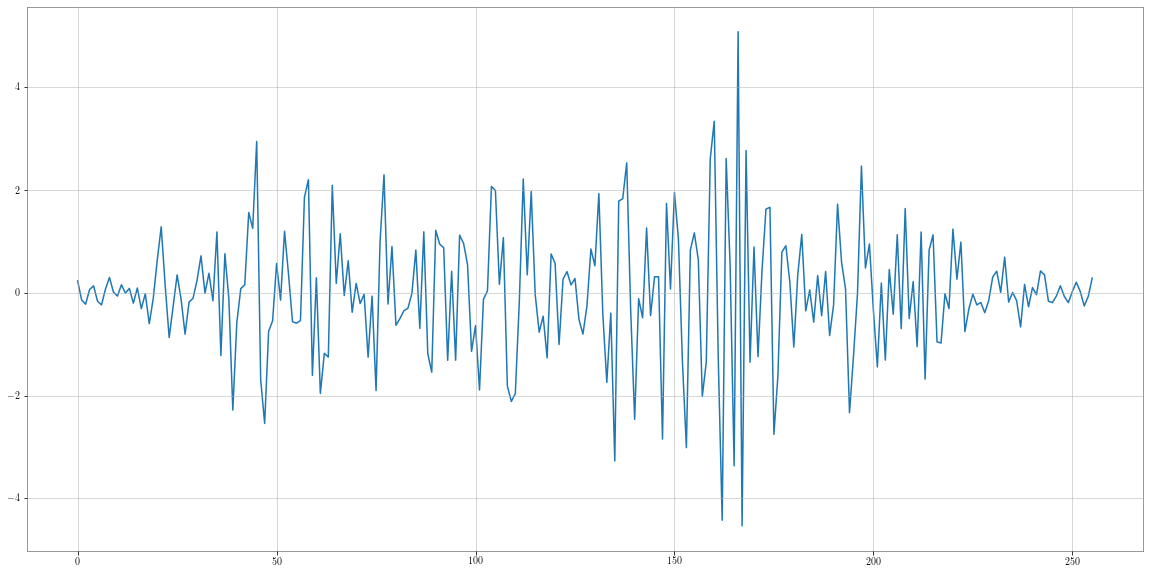

In [8]:
fig, ax = plt.subplots(figsize = (20,10))
#ax.plot(np.array(H1_ts.crop(start = trigger_time - 0.75, end = trigger_time + 1.25)))
ax.plot(whitened_h[0][:,0])

In [9]:
tseries = TimeSeries(whitened_h_td, sample_rate=ifo.sampling_frequency)

In [10]:
spect = tseries.spectrogram(stride = 0.2, fftlength = 0.2, overlap = 0.1,window = "hamming")

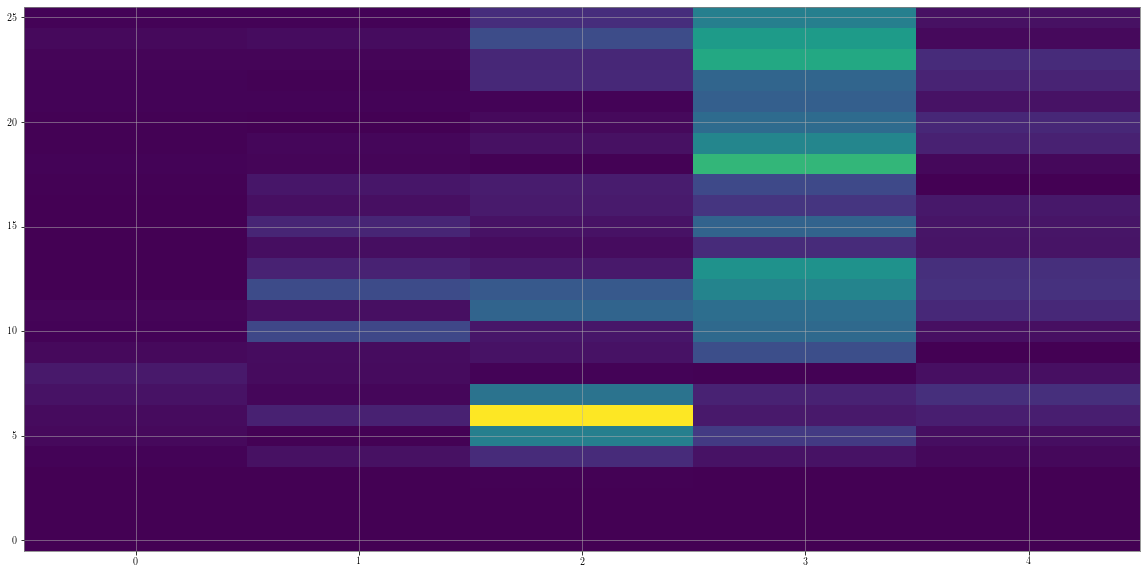

In [11]:
fig, ax = plt.subplots(figsize = (20,10))
ax.imshow(np.array(spect[:,:400]).T, aspect = "auto",origin="lower",interpolation= "none")

In [11]:
params_dir = model_dir#"../vitamin_c/params_files"
params_file = os.path.join(params_dir,'params.json')                                                                                                                 
bounds_file = os.path.join(params_dir,'bounds.json')                                                                                                                 
#fixed_vals_file = os.path.join(params_dir,'fixed_vals.json')                                                                                                         
                                                                                                                                                                         
EPS = 1e-3                                                                                                                                                           
                                                                                                                                                                         
# Load parameters files                                                                                                                                              
with open(params_file, 'r') as fp:                                                                                                                                   
    params = json.load(fp)                                                                                                                                           
with open(bounds_file, 'r') as fp:                                                                                                                                   
    bounds = json.load(fp)                                                                                                                                           
#with open(fixed_vals_file, 'r') as fp:                                                                                                                               
#    fixed_vals = json.load(fp) 
    
#params["ref_geocent_time"] = start_time + 0.5

In [12]:
params, bounds, masks, fixed_vals = get_params(params, bounds, fixed_vals = None)

... converted RA bounds to hour angle
[False, False, True, False, False, False, False, False, False, False, False, False, False, True, True]
[True, True, False, True, True, True, True, True, True, True, True, True, True, False, False]
[ 3  4  0  5  6  7  8  9 10 11 12 13 14  1  2]
['mass_1', 'mass_2', 'luminosity_distance', 'geocent_time', 'phase', 'theta_jn', 'psi', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'ra', 'dec']
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] []
[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True] [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False] [0]
[False, True, False, False, False, False, False, False, False, False, False, False, False, False, False] [1]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [14]:
#sys.path.append("/home/joseph.bayley/public_html/")
model = CVAE(params, bounds = bounds, masks = masks)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 225, 64)           4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 112, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 32)            32800     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 32)            8224      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 16)            4112  

In [15]:
latest = tf.train.latest_checkpoint(os.path.join(model_dir,"checkpoint"))
model.load_weights(latest)

In [96]:
np.shape(resamp_whitened)

(1, 256, 2)

In [8]:
1 % 2*np.pi

3.141592653589793

In [10]:
np.remainder([-1,np.pi,2,7], 2*np.pi)

array([5.28318531, 3.14159265, 2.        , 0.71681469])

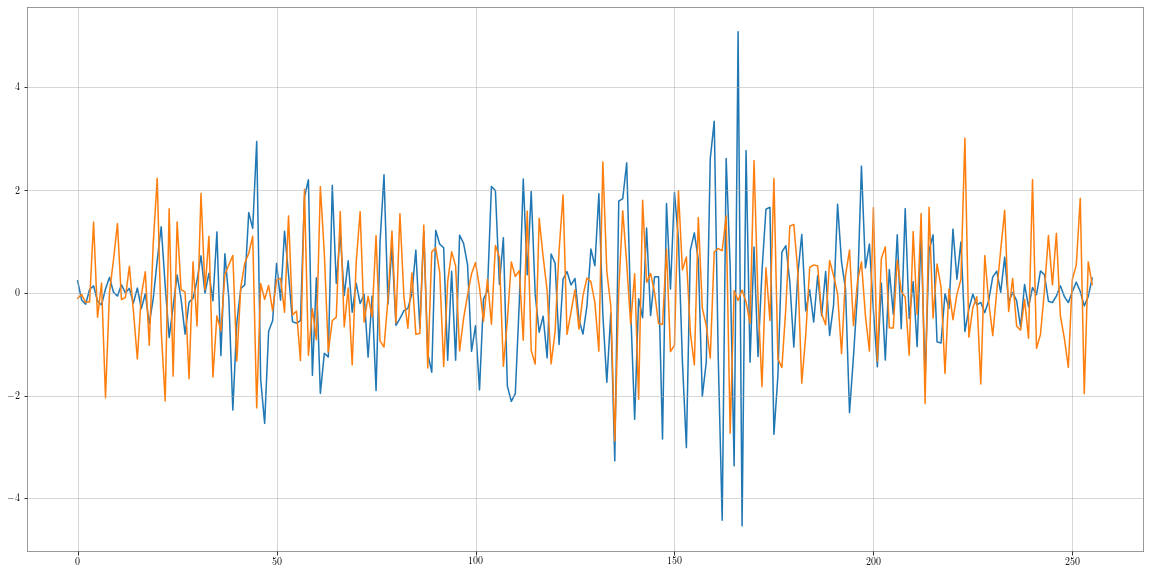

In [17]:
fig, ax = plt.subplots(figsize = (20,10))
#ax.plot(np.array(H1_ts.crop(start = trigger_time - 0.75, end = trigger_time + 1.25)))
ax.plot(whitened_h[0][:,0])
#ax.plot(whitened_h[0][:,1])
#ax.plot(np.array(H1d),".")
ax.plot(y_data_test[0][:,0])
#ax.plot(y_data_test[0][:,1])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  8.,
        16., 28., 40., 46., 55., 28., 13.,  4.,  5.,  3.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([-7.        , -6.51724138, -6.03448276, -5.55172414,
        -5.06896552, -4.5862069 , -4.10344828, -3.62068966,
        -3.13793103, -2.65517241, -2.17241379, -1.68965517,
        -1.20689655, -0.72413793, -0.24137931,  0.24137931,
         0.72413793,  1.20689655,  1.68965517,  2.17241379,
         2.65517241,  3.13793103,  3.62068966,  4.10344828,
         4.5862069 ,  5.06896552,  5.55172414,  6.03448276,
         6.51724138,  7.        ]),
 <BarContainer object of 29 artists>)

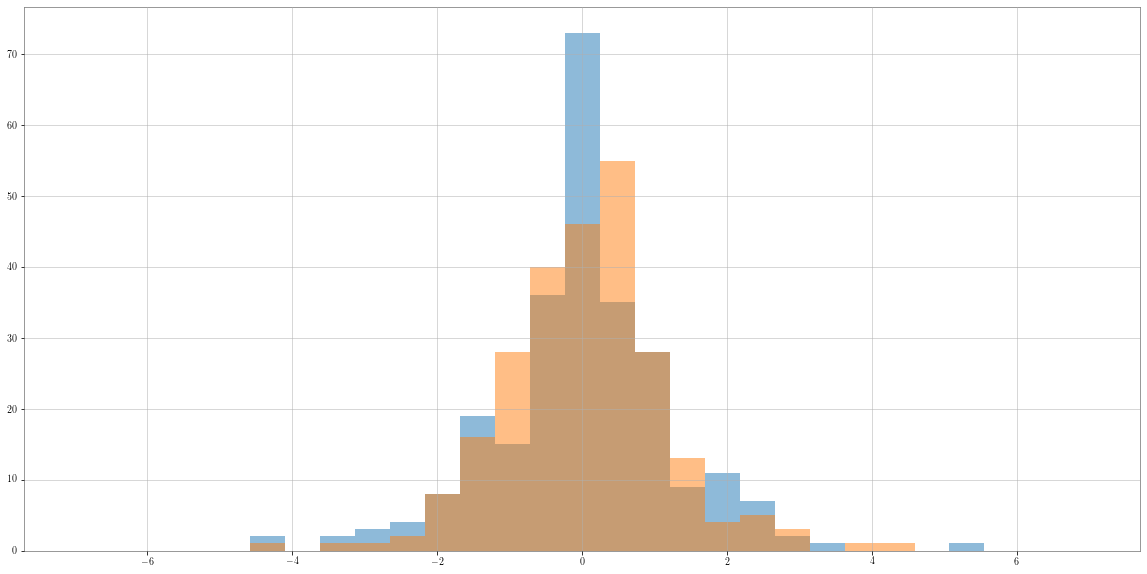

In [29]:
fig, ax = plt.subplots(figsize = (20,10))
#ax.plot(np.array(H1_ts.crop(start = trigger_time - 0.75, end = trigger_time + 1.25)))
bins = np.linspace(-7,7,30)
ax.hist(whitened_h[0][:,0], alpha = 0.5, bins = bins)
#ax.plot(whitened_h[0][:,1])
#ax.plot(np.array(H1d),".")
ax.hist(y_data_test[1][:,0], alpha = 0.5, bins = bins)
#ax.plot(y_data_test[0][:,1])

In [16]:
samples = model.gen_samples(np.array(whitened_h), nsamples = 5000)

In [19]:
plot_posterior(samples, None,1, 1,run="./", params=params, bounds = bounds, masks=masks)

identified 4851 good samples
()


-1.0

# add gregs dynesty posterior

In [3]:
with open("/home/joseph.bayley/data/CBC/O4MDC/greg_bilby/O4MDC_U1_data0_1325030417-924_analysis_H1L1_bilby_mcmc_merge_result.json","r") as f:
    samples_g = json.load(f)

In [38]:
samples_g.keys()

dict_keys(['label', 'outdir', 'sampler', 'log_evidence', 'log_evidence_err', 'log_noise_evidence', 'log_bayes_factor', 'priors', 'posterior', 'injection_parameters', 'meta_data', 'search_parameter_keys', 'fixed_parameter_keys', 'constraint_parameter_keys', 'sampling_time', 'sampler_kwargs', 'use_ratio', 'information_gain', 'log_likelihood_evaluations', 'log_prior_evaluations', 'samples', 'parameter_labels', 'parameter_labels_with_unit', 'version'])

In [36]:
samples_g["posterior"]["content"].keys()

dict_keys(['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'theta_jn', 'psi', 'phase', 'azimuth', 'zenith', 'time_jitter', 'luminosity_distance', 'geocent_time', 'log_likelihood', 'log_prior', 'reference_frequency', 'waveform_approximant', 'minimum_frequency', 'ra', 'dec', 'H1_matched_filter_snr', 'H1_optimal_snr', 'L1_matched_filter_snr', 'L1_optimal_snr', 'total_mass', 'mass_1', 'mass_2', 'symmetric_mass_ratio', 'iota', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'phi_1', 'phi_2', 'chi_eff', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_p', 'cos_tilt_1', 'cos_tilt_2', 'redshift', 'comoving_distance', 'mass_1_source', 'mass_2_source', 'chirp_mass_source', 'total_mass_source'])

In [21]:
with open("/home/joseph.bayley/data/CBC/O4MDC/greg_dynesty/O4MDC_U1_data0_1325030417-924_analysis_H1L1_dynesty_samples.dat","r") as f:
    params = f.readline()
    samples_g1 = np.loadtxt(f)

In [4]:
samples_g["posterior"]["content"].keys()

dict_keys(['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'theta_jn', 'psi', 'phase', 'azimuth', 'zenith', 'time_jitter', 'luminosity_distance', 'geocent_time', 'log_likelihood', 'log_prior', 'reference_frequency', 'waveform_approximant', 'minimum_frequency', 'ra', 'dec', 'H1_matched_filter_snr', 'H1_optimal_snr', 'L1_matched_filter_snr', 'L1_optimal_snr', 'total_mass', 'mass_1', 'mass_2', 'symmetric_mass_ratio', 'iota', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'phi_1', 'phi_2', 'chi_eff', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_p', 'cos_tilt_1', 'cos_tilt_2', 'redshift', 'comoving_distance', 'mass_1_source', 'mass_2_source', 'chirp_mass_source', 'total_mass_source'])

In [22]:
pars = ["mass_1","mass_2","luminosity_distance","geocent_time","phase","theta_jn","psi","a_1","a_2","tilt_1","tilt_2","phi_12","phi_jl","ra","dec"]

In [37]:
samples_g2 = []
for par in pars:
    samples_g2.append(samples_g["posterior"]["content"][par])
samples_g2 = np.array(samples_g2).T

In [ ]:
samples_g2 = []
for ind in range(len(samples_g) - 1):
    
    temp_samp = np.array(samples_g[ind + 1].strip("\n").split(" ")).astype(float)[inds]
    samples_g2.append(temp_samp)

In [10]:
dct = bilby.gw.prior.BBHPriorDict()

08:52 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [18]:
dct.

dict_values([Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None), Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None), Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None), Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None), UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None), Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None), Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic'), Sine(minimum=0, maximum=3.141592653589793, name='theta_jn', latex_label='$\\theta_{JN}$

In [12]:
dct.to_file("./test.prior",label="test")

In [6]:
prior_dict={mass_1 = bilby.gw.prior.Uniform(name='mass_1', minimum=5, maximum=100,unit='$M_{\odot}$'), 
            mass_2 = bilby.gw.prior.Uniform(name='mass_1', minimum=5, maximum=100,unit='$M_{\odot}$'), 
            a_1 = bilby.gw.prior.Uniform(name='a_1', minimum=0, maximum=0.99), 
            a_2 = bilby.gw.prior.Uniform(name='a_1', minimum=0, maximum=0.99), 
            tilt_1 = bilby.core.prior.Sine(name='tilt_1', minimum=0, maximum=np.pi), 
            tilt_2 = bilby.core.prior.Sine(name='tilt_1', minimum=0, maximum=np.pi), 
            phi_12 = bilby.gw.prior.Uniform(name='phi_12', minimum=0, maximum=2*np.pi, boundary='periodic'), 
            phi_jl = bilby.gw.prior.Uniform(name='phi_jl', minimum=0, maximum=2*np.pi, boundary='periodic'), 
            luminosity_distance = bilby.gw.prior.Uniform(name='luminosity_distance', minimum=100, maximum=5000, unit='Mpc'), 
            dec = bilby.gw.prior.Cosine(minimum=-np.pi/2, maximum=np.pi/2, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None), 
            ra = bilby.gw.prior.Uniform(name='ra', minimum=0, maximum=2*np.pi, boundary='periodic'), 
            theta_jn = bilby.gw.prior.Sine(minimum=0, maximum=np.pi, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, boundary=None), 
            psi = bilby.gw.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'), 
            phase = bilby.gw.prior.Uniform(name='phase', minimum=0, maximum=2*np.pi, boundary='periodic'), }


NameError: name 'Constraint' is not defined

# add michaels posteriors

In [13]:
with open("/home/joseph.bayley/data/CBC/O4MDC/michael_posterior/DEV0_pesummary.dat","r") as f:
    samples_m = f.readlines()

In [14]:
samples_m[0]

'mass_ratio\tchirp_mass\tluminosity_distance\tdec\tra\ttheta_jn\tpsi\ta_1\ta_2\ttilt_1\ttilt_2\tphi_12\tphi_jl\tgeocent_time\tlog_prior\tlog_likelihood\tphase\ttotal_mass\tmass_1\tmass_2\tsymmetric_mass_ratio\tiota\tspin_1x\tspin_1y\tspin_1z\tspin_2x\tspin_2y\tspin_2z\tphi_1\tphi_2\tchi_eff\tchi_1_in_plane\tchi_2_in_plane\tchi_p\tcos_tilt_1\tcos_tilt_2\tredshift\tcomoving_distance\tmass_1_source\tmass_2_source\tchirp_mass_source\ttotal_mass_source\tH1_matched_filter_snr\tH1_optimal_snr\tL1_matched_filter_snr\tL1_optimal_snr\tH1_matched_filter_abs_snr\tH1_matched_filter_snr_angle\tL1_matched_filter_abs_snr\tL1_matched_filter_snr_angle\tinverted_mass_ratio\tfinal_spin_non_evolved\tpeak_luminosity_non_evolved\tfinal_mass_non_evolved\tfinal_mass_source_non_evolved\tradiated_energy_non_evolved\tH1_time\tL1_time\tnetwork_optimal_snr\tnetwork_matched_filter_snr\tcos_theta_jn\tcos_iota\n'

In [19]:
pars = ["mass_1","mass_2","luminosity_distance","geocent_time","phase","theta_jn","psi","a_1","a_2","tilt_1","tilt_2","phi_12","phi_jl","ra","dec"]

In [48]:
inds = []
for par in pars:
    for ind,allp in enumerate(samples_m[0].strip("\n").split("\t")):
        if par == allp:
            inds.append(ind)
            break

In [49]:
inds

[18, 19, 2, 13, 16, 5, 6, 7, 8, 9, 10, 11, 12, 4, 3]

In [50]:
len(samples_m)

9262

In [56]:
samples_m2 = []
for ind in range(len(samples_m) - 1):
    
    temp_samp = np.array(samples_m[ind + 1].strip("\n").split("\t")).astype(float)[inds]
    samples_m2.append(temp_samp)
    

In [57]:
np.shape(samples_m2)

(9261, 15)

In [60]:
np.mean(np.array(samples_m2)[:,0])

40.526416333469264

# testing the sky position

In [ ]:
#params["ref_geocent_time"] = params["ref_geocent_time"] - 0.1

In [21]:
print(samples[:,-2])
samp2 = load_data_fit.convert_hour_angle_to_ra(np.array(samples), params, pars)
print(samp2[:,-2])

tf.Tensor(
[0.81980634 0.71592486 0.6927277  ... 0.23090458 0.16936949
 0.8857723 ], shape=(5000,), dtype=float32)
[0.85265267 0.95653415 0.9797313  ... 1.4415544  1.5030895
 0.7866867 ]


In [20]:
print(samples[:,-2])
samp2 = load_data_fit.convert_ra_to_hour_angle(np.array(samples), params, pars)
print(samp2[:,-2])

tf.Tensor(
[0.81980634 0.71592486 0.6927277  ... 0.23090458 0.16936949
 0.8857723 ], shape=(5000,), dtype=float32)
[0.85265267 0.95653415 0.9797313  ... 1.4415544  1.5030895
 0.7866867 ]


In [41]:
params["ref_geocent_time"] = params["ref_geocent_time"] - 3600

In [42]:
sampb = load_data.convert_hour_angle_to_ra(np.array(samp2), params, pars)
print(sampb[:,-2])

[0.7201253 6.27104   6.115347  ... 6.2348504 6.2669096 6.238929 ]


In [39]:
print(sampb[:,-2])

[0.9826415  0.25037077 0.09467785 ... 0.21418111 0.2462403
 0.2182595 ]


In [40]:
print(samples[:,-2])

tf.Tensor(
[0.9826415  0.25037083 0.09467781 ... 0.21418114 0.24624026
 0.2182595 ], shape=(5000,), dtype=float32)


In [38]:
greenwich = coord.EarthLocation.of_site('greenwich')
t = Time(params['ref_geocent_time'], format='gps', location=greenwich)
t = t.sidereal_time('mean', 'greenwich').radian
print(t)

1.6724589976812902


In [39]:
st2 = start_time + 0.5

In [41]:
print(st2 - params['ref_geocent_time'])

1142.415282011032


In [40]:
greenwich = coord.EarthLocation.of_site('greenwich')
t = Time(st2, format='gps', location=greenwich)
t = t.sidereal_time('mean', 'greenwich').radian
print(t)

1.7557652438413835


# testing resampling

In [12]:
np.shape(samples)

TensorShape([5000, 15])

In [43]:
new_samples = np.zeros([samples.shape[0],masks["inf_ol_len"]])
cnt = 0
for inf_idx,bilby_idx in zip(masks["inf_ol_idx"],masks["bilby_ol_idx"]):
    inf_par = params['inf_pars'][inf_idx]
    new_samples[:,cnt] = (samples[:,inf_idx] * (bounds[inf_par+'_max'] - bounds[inf_par+'_min'])) + bounds[inf_par+'_min']
    cnt += 1

In [30]:
new_distprior = bilby.gw.prior.BBHPriorDict()["luminosity_distance"]

03:34 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [31]:
old_distprior = bilby.gw.prior.Uniform(name='luminosity_distance', minimum=bounds['luminosity_distance_min'], maximum=bounds['luminosity_dista\
nce_max'], unit='Mpc')

In [48]:
prior_ratios = []
for i in range(len(new_samples)):
    val = new_distprior.prob(new_samples[i][2])/old_distprior.prob(new_samples[i][2])
    prior_ratios.append(val)

In [97]:
prior_ratios = prior_ratios/np.sum(prior_ratios)

In [71]:
r_num = np.random.rand(len(prior_ratios))

In [102]:
inds = np.where(prior_ratios/max(prior_ratios) > r_num)[0]

In [103]:
np.shape(samples.numpy()[inds])

(2243, 15)

In [89]:
np.shape(new_samples)

(5000, 14)

In [104]:
resampled = np.array(random.choices(new_samples, weights = prior_ratios, k = len(samples)))

In [90]:
np.shape(resampled)

(5000, 14)

In [94]:
resamp2 = new_samples[inds]

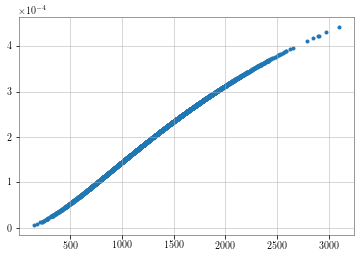

In [105]:
fig, ax = plt.subplots()
vals = np.linspace(100, 5000, 100)
ax.plot(new_samples[:,2],prior_ratios,".")

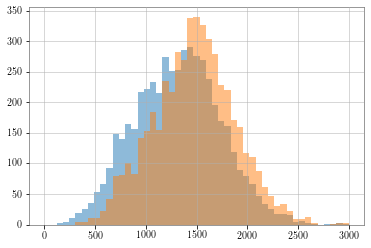

In [106]:
fig, ax = plt.subplots()
bins = np.linspace(0,3000,50)
hst = ax.hist(new_samples[:,2], bins = bins, alpha =  0.5)
hst2 = ax.hist(resampled[:,2], bins = bins, alpha = 0.5)
#hst3 = ax.hist(resamp2[:,2], bins = bins, alpha = 0.5)

In [10]:
train_dataset = load_data_fit.DataLoader(params["train_set_dir"],params = params,bounds = bounds, masks = masks,fixed_vals = fixed_vals, chunk_batch = 40)

In [13]:
train_dataset.load_next_chunk()

../vitamin_c/load_data_fit.py:170: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['x_data'] = np.concatenate(np.array(data['x_data']), axis=0).squeeze()
../vitamin_c/load_data_fit.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['y_data_noisefree'] = np.transpose(np.concatenate(np.array(data['y_data_noisefree']), axis=0),[0,2,1])
../vitamin_c/load_data_fit.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

load_time chunk 0: 4.223323822021484


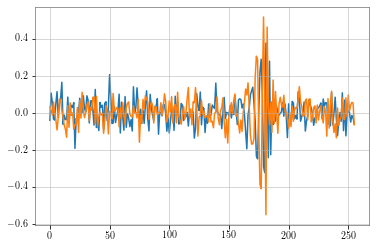

In [25]:
fig, ax = plt.subplots()
ax.plot(train_dataset.Y_noisefree[3][:,0])
ax.plot(train_dataset.Y_noisefree[3][:,1])

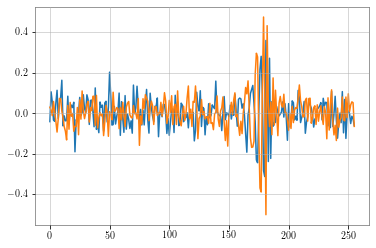

In [24]:
fig, ax = plt.subplots()
ax.plot(tf.keras.activations.tanh(train_dataset.Y_noisefree[3][:,0]))
ax.plot(tf.keras.activations.tanh(train_dataset.Y_noisefree[3][:,1]))